In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import copy

In [2]:
linear_trend = np.linspace(0, 10, 5)

In [3]:
x = np.linspace(0, 10 * np.pi, 10)
increasing_sine_wave = np.sin(x) + 0.1 * x  # Increasing sine wave

In [4]:
exponential_trend = np.exp(np.linspace(0, 2, 13))

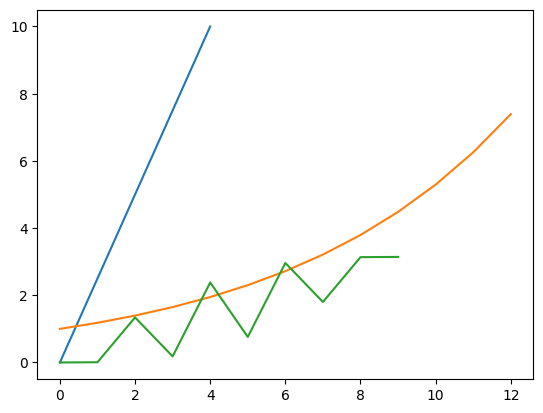

In [5]:
plt.plot(linear_trend)
plt.plot(exponential_trend)
plt.plot(increasing_sine_wave)
# plt.legend(['linear', ''])
plt.show()

In [6]:
print(linear_trend)
print(exponential_trend)
print(increasing_sine_wave)

[ 0.   2.5  5.   7.5 10. ]
[1.         1.18136041 1.39561243 1.64872127 1.94773404 2.30097589
 2.71828183 3.21127054 3.79366789 4.48168907 5.29449005 6.25470095
 7.3890561 ]
[0.         0.00704571 1.34091931 0.18117215 2.38107115 0.7605215
 2.96042051 1.80067334 3.13454695 3.14159265]


# trend data

In [7]:
np.random.seed(42)  # for reproducibility
n_samples = 10000
ages = np.concatenate([
    np.random.normal(60, 10, int(0.8 * n_samples)),  # 70% of the data around age 60
    np.random.normal(30, 10, int(0.2 * n_samples))   # 30% of the data around age 30
])
ages = np.clip(ages, 0, 100)  

In [8]:
def generate_trends(num_sequences, max_length, beta, noise):
    np.random.seed(42)  # for reproducibility
    data = {}

    for patid in tqdm(range(num_sequences)):
        length = np.random.randint(5, max_length)
        trend_type = np.random.choice(['increasing', 'decreasing'])
        x = np.linspace(0, 1, length)
        
        if trend_type == 'increasing':
            y = np.polyval(np.polyfit(x, np.random.rand(length) + np.linspace(0, 2, length), 2), x) +ages[patid]*beta
        else:
            y = np.polyval(np.polyfit(x, np.random.rand(length) + np.linspace(2, 0, length), 2), x) +ages[patid]*beta

        # Adding some noise
        y += np.random.normal(scale=noise, size=length)
        
        # Ensuring no exact linear trends
        y = y + np.sin(2 * np.pi * np.random.rand() * x)
        
        data[patid] = {}
        data[patid]['seq'] = y
        data[patid]['age'] = ages[patid]
        if trend_type == 'increasing':
            data[patid]['label'] = 1
        else:
            data[patid]['label'] = 0

    return data

# Generate 10 sequences with a maximum length of 50
trends_data = generate_trends(10000, 50, 0.1, 0.6)


100%|██████████| 10000/10000 [00:01<00:00, 5867.62it/s]


In [9]:
la = []
for k,v in trends_data.items():
    la.append(v['label'])

In [10]:
sum(la)

5079

6.542945507351557


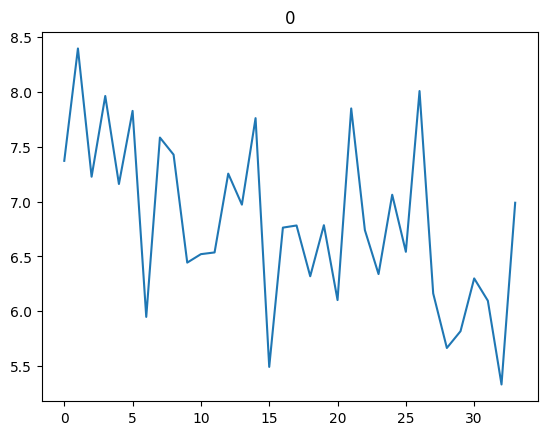

In [11]:
i = 2546
plt.plot(trends_data[i]['seq'])
plt.title(trends_data[i]['label'])
print(trends_data[i]['seq'][25])

In [12]:
import pickle
with open('datasets/noise0.6_beta0.1.pickle','wb') as handle:
    pickle.dump(trends_data, handle)

# Trend data with missingness

In [13]:
def calculate_missingness(data):
    # Calculate total values and missing values across all sequences in the data
    total_values = sum(len(values['seq']) for values in data.values())
    missing_values = sum(np.isnan(values['seq']).sum() for values in data.values())
    # Return the overall missing rate
    return missing_values / total_values

### missing completely at random (MCAR)

In [14]:
import copy

In [15]:
def introduce_mcar(data, missing_rate=0.3):
    np.random.seed(111)
    for patid, values in data.items():
        seq = values['seq']
        mask = np.random.rand(len(seq)) > missing_rate # if random number is greater than missing_rate, the value will be kept. As the random number is from 0 to 1 there are 1-missing_rate percent chance that the value will be kept
        seq[~mask] = np.nan  # Introducing missing values
        data[patid]['seq'] = seq
    return data

In [16]:
import pickle
with open('datasets/noise0.6_beta0.1.pickle','rb') as handle:
    trends_data = pickle.load(handle)

In [17]:
data_miss = introduce_mcar(copy.deepcopy(trends_data))

Text(0.5, 1.0, '0')

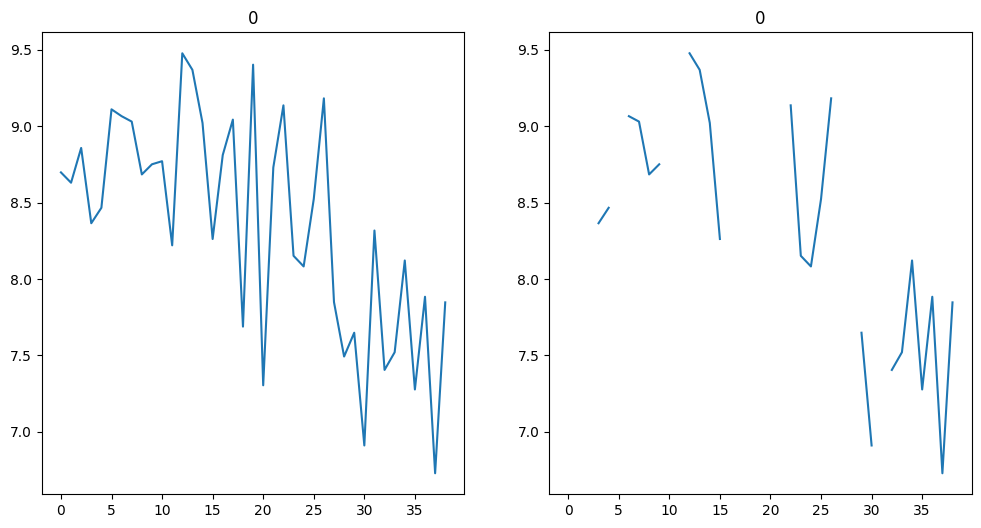

In [18]:
# miss = 0.1
i = 70
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(trends_data[i]['seq'])
axes[0].set_title(trends_data[i]['label'])

axes[1].plot(data_miss[i]['seq'])
axes[1].set_title(data_miss[i]['label'])

In [19]:
data_miss[0]

{'seq': array([9.56717963,        nan, 9.16822658, 7.85247289,        nan,
               nan,        nan, 9.07508737,        nan, 8.76370568,
        8.04298938,        nan,        nan, 9.51919765, 9.07494484,
               nan, 9.02878058,        nan,        nan, 9.14315123,
        9.37332568, 9.29095372, 8.20493469, 8.49798201, 8.8560254 ,
        9.21501931, 8.31323731,        nan, 7.87476784,        nan,
        8.9580173 , 9.24794569, 8.35316391,        nan, 8.53306131,
               nan, 8.44645261, 9.10690611, 8.11554341, 9.02728596,
        6.46664398, 8.4801838 , 7.98641582]),
 'age': np.float64(64.96714153011233),
 'label': 0}

In [20]:
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

In [21]:
with open('datasets/mcar0.3_beta0.1.pickle','wb') as handle:
    pickle.dump(data_miss, handle)


In [22]:
with open('datasets/noise0.6_beta0.1.pickle','rb') as handle:
    trends_data = pickle.load(handle)
data_miss = introduce_mcar(copy.deepcopy(trends_data), missing_rate=0.6)
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp
with open('datasets/mcar0.6_beta0.1.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [23]:
max_len = 0
for i, d in data_miss.items():
    if max_len<len(d['seq']):
        max_len = len(d['seq'])

In [24]:
max_len

49

### Missing at random (MAR)

In [25]:
def introduce_mar(data, target_missing_rate=0.3, max_iter=100):
    np.random.seed(111)  # Set seed for reproducibility
    tolerance = 0.01  # Tolerance for reaching the target missing rate

    # Extract sequences and ages into arrays
    original_sequences = [np.array(values['seq']) for values in data.values()]
    ages = np.array([float(values['age']) for values in data.values()])

    # Initial missing rates for the two groups
    missing_rate_below_50 = target_missing_rate * 0.5  # Start with half of the target for below 50
    missing_rate_above_50 = target_missing_rate * 1.5  # Start with 1.5x the target for above 50

    for iteration in range(max_iter):
        # Reset sequences to original before each iteration to avoid cumulative missingness
        sequences = [seq.copy() for seq in original_sequences]
        
        # Introduce missing values based on age groups
        for i, seq in enumerate(sequences):
            if ages[i] > 50:
                # Apply higher missing rate for patients above 50
                mask = np.random.rand(len(seq)) > missing_rate_above_50
            else:
                # Apply lower missing rate for patients 50 or below
                mask = np.random.rand(len(seq)) > missing_rate_below_50
            
            seq[~mask] = np.nan  # Set values to NaN based on the mask
        
        # Update the sequences back into the data structure for missingness calculation
        for i, (patid, values) in enumerate(data.items()):
            values['seq'] = sequences[i].tolist()

        # Calculate the overall missing rate using the provided function
        actual_missing_rate = calculate_missingness(data)
        
        # Print the actual missing rate after each iteration
        print(f"Iteration {iteration + 1}: Actual Missing Rate = {actual_missing_rate:.4f}")
        
        # Break if the actual missing rate is within the acceptable tolerance of the target
        if abs(actual_missing_rate - target_missing_rate) < tolerance:
            break
        
        # Adjust missing rates for both age groups based on the overall missing rate
        if actual_missing_rate > target_missing_rate:
            # Decrease both rates if the overall missing rate is too high
            missing_rate_above_50 *= 0.95
            missing_rate_below_50 *= 0.95
        else:
            # Increase both rates if the overall missing rate is too low
            missing_rate_above_50 *= 1.05
            missing_rate_below_50 *= 1.05

        # Ensure the missing rates are within reasonable bounds [0, 1]
        missing_rate_above_50 = min(max(missing_rate_above_50, 0), 1)
        missing_rate_below_50 = min(max(missing_rate_below_50, 0), 1)
    
    # Output the final missing rates and actual missing rate achieved
    print(f'Final Missing Rate Above 50: {missing_rate_above_50:.4f}')
    print(f'Final Missing Rate Below 50: {missing_rate_below_50:.4f}')
    print(f'Actual Missing Rate: {actual_missing_rate:.4f}')
    
    return data

Iteration 1: Actual Missing Rate = 0.3548
Iteration 2: Actual Missing Rate = 0.3371
Iteration 3: Actual Missing Rate = 0.3206
Iteration 4: Actual Missing Rate = 0.3046
Final Missing Rate Above 50: 0.3858
Final Missing Rate Below 50: 0.1286
Actual Missing Rate: 0.3046


Text(0.5, 1.0, '0')

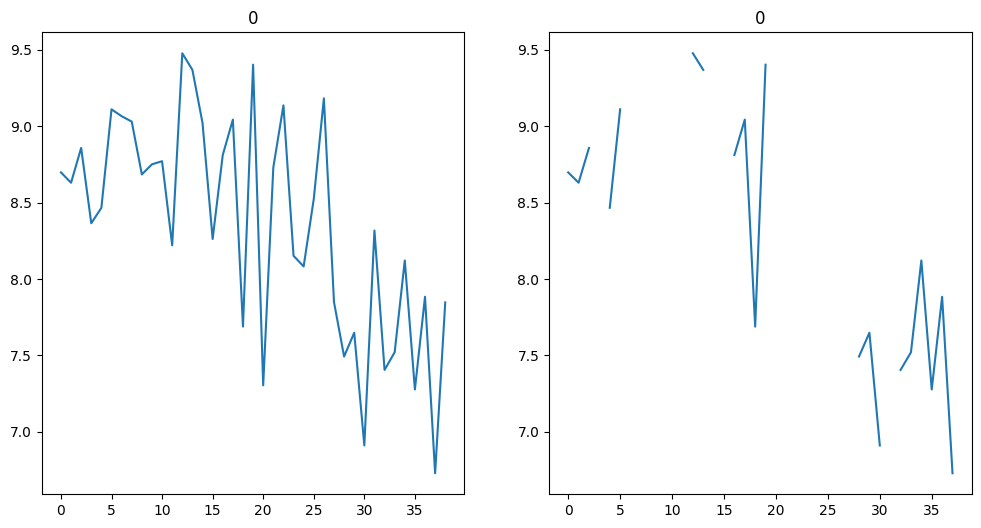

In [26]:
with open('datasets/noise0.6_beta0.1.pickle','rb') as handle:
    trends_data = pickle.load(handle)
    
data_miss = introduce_mar(copy.deepcopy(trends_data))

# miss = 0.1
i = 70
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(trends_data[i]['seq'])
axes[0].set_title(trends_data[i]['label'])

axes[1].plot(data_miss[i]['seq'])
axes[1].set_title(data_miss[i]['label'])


In [27]:
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

In [28]:
with open('datasets/mar0.3_beta0.1.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [29]:
with open('datasets/noise0.6_beta0.1.pickle','rb') as handle:
    trends_data = pickle.load(handle)
    
data_miss = introduce_mar(copy.deepcopy(trends_data), target_missing_rate=0.6)

for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp
    
with open('datasets/mar0.6_beta0.1.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

Iteration 1: Actual Missing Rate = 0.7078
Iteration 2: Actual Missing Rate = 0.6724
Iteration 3: Actual Missing Rate = 0.6399
Iteration 4: Actual Missing Rate = 0.6074
Final Missing Rate Above 50: 0.7716
Final Missing Rate Below 50: 0.2572
Actual Missing Rate: 0.6074


In [30]:
max_len = 0
for i, d in data_miss.items():
    if max_len<len(d['seq']):
        max_len = len(d['seq'])
max_len

49

### Missing not at random (MNAR)

In [31]:
def introduce_mnar(data, target_missing_rate=0.3, max_iter=100):
    np.random.seed(111)  # Set seed for reproducibility
    tolerance = 0.01  # Tolerance for reaching the target missing rate

    # Extract sequences into arrays
    original_sequences = [np.array(values['seq']) for values in data.values()]

    # Initial missing rates for values above and below 7
    missing_rate_below_7 = target_missing_rate * 0.5  # Start with half of the target for values <= 7
    missing_rate_above_7 = target_missing_rate * 1.5  # Start with 1.5x the target for values > 7

    for iteration in range(max_iter):
        # Reset sequences to original before each iteration to avoid cumulative missingness
        sequences = [seq.copy() for seq in original_sequences]
        
        # Introduce missing values based on value conditions
        for seq in sequences:
            # Create a mask where missing rate depends on whether the value is above 7
            mask_below_7 = (seq <= 7) & (np.random.rand(len(seq)) > missing_rate_below_7)
            mask_above_7 = (seq > 7) & (np.random.rand(len(seq)) > missing_rate_above_7)
            
            # Combine masks to apply missing values
            mask = mask_below_7 | mask_above_7
            seq[~mask] = np.nan  # Set values to NaN based on the combined mask
        
        # Update the sequences back into the data structure for missingness calculation
        for i, (patid, values) in enumerate(data.items()):
            values['seq'] = sequences[i].tolist()

        # Calculate the overall missing rate using the provided function
        actual_missing_rate = calculate_missingness(data)
        
        # Print the actual missing rate after each iteration
        print(f"Iteration {iteration + 1}: Actual Missing Rate = {actual_missing_rate:.4f}")
        
        # Break if the actual missing rate is within the acceptable tolerance of the target
        if abs(actual_missing_rate - target_missing_rate) < tolerance:
            break
        
        # Adjust missing rates for values above and below 7 based on the overall missing rate
        if actual_missing_rate > target_missing_rate:
            # Decrease both rates if the overall missing rate is too high
            missing_rate_above_7 *= 0.95
            missing_rate_below_7 *= 0.95
        else:
            # Increase both rates if the overall missing rate is too low
            missing_rate_above_7 *= 1.05
            missing_rate_below_7 *= 1.05

        # Ensure the missing rates are within reasonable bounds [0, 1]
        missing_rate_above_7 = min(max(missing_rate_above_7, 0), 1)
        missing_rate_below_7 = min(max(missing_rate_below_7, 0), 1)
    
    # Output the final missing rates and actual missing rate achieved
    print(f'Final Missing Rate Above 7: {missing_rate_above_7:.4f}')
    print(f'Final Missing Rate Below or Equal to 7: {missing_rate_below_7:.4f}')
    print(f'Actual Missing Rate: {actual_missing_rate:.4f}')
    
    return data

Iteration 1: Actual Missing Rate = 0.3299
Iteration 2: Actual Missing Rate = 0.3146
Iteration 3: Actual Missing Rate = 0.2996
Final Missing Rate Above 7: 0.4061
Final Missing Rate Below or Equal to 7: 0.1354
Actual Missing Rate: 0.2996


Text(0.5, 1.0, '0')

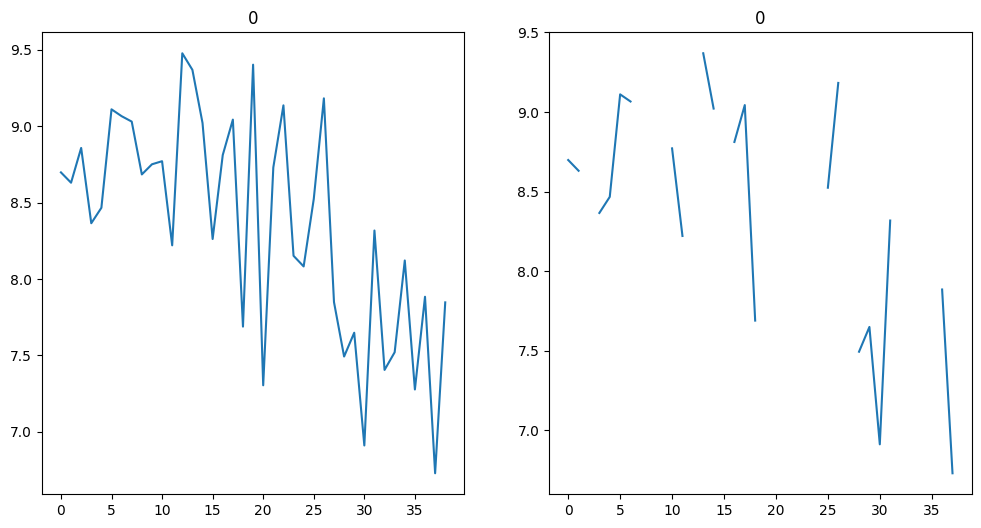

In [32]:
import pickle
with open('datasets/noise0.6_beta0.1.pickle','rb') as handle:
    trends_data = pickle.load(handle)
    
data_miss = introduce_mnar(copy.deepcopy(trends_data))

# miss = 0.1
i = 70
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(trends_data[i]['seq'])
axes[0].set_title(trends_data[i]['label'])

axes[1].plot(data_miss[i]['seq'])
axes[1].set_title(data_miss[i]['label'])

In [33]:
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

In [34]:
with open('datasets/mnar0.3_beta0.1.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [35]:
with open('datasets/noise0.6_beta0.1.pickle','rb') as handle:
    trends_data = pickle.load(handle)
    
data_miss = introduce_mnar(copy.deepcopy(trends_data), target_missing_rate=0.6)
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

with open('datasets/mnar0.6_beta0.1.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

Iteration 1: Actual Missing Rate = 0.6603
Iteration 2: Actual Missing Rate = 0.6272
Iteration 3: Actual Missing Rate = 0.5967
Final Missing Rate Above 7: 0.8122
Final Missing Rate Below or Equal to 7: 0.2707
Actual Missing Rate: 0.5967


In [36]:
max_len = 0
for i, d in data_miss.items():
    if max_len<len(d['seq']):
        max_len = len(d['seq'])
max_len

49

# model training/evaluation

In [37]:
name = 'noise0.6_beta0.1'
model_name = 'mlp_fix'
#add_annot = '_lr0.05'

In [38]:
import pickle
with open('datasets/'+name+'.pickle','rb') as handle:
    trends_data = pickle.load(handle)

In [39]:
from training import Training
import torch
# torch.cuda.set_device(0)
device = torch.device('cpu')
# training = Training(trends_data, model = model_name, device = device)
# training = Training(trends_data, model = model_name, hidden_dim = 1536, device = device)
# training = Training(trends_data, model = model_name, input_dim = 1536, hidden_dim=128, device = device)
training = Training(trends_data, model = model_name, input_dim = 49, hidden_dim=1536, device = device)

normalize data
create datasets
create trainloaders


In [1]:
import torch
import pickle
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Set the device for PyTorch (use 'cuda' for GPU if available)
device = torch.device('cpu')  # Change to 'cuda' if using GPU
random.seed(111)
# Define lists for model configurations you want to try
model_names = ['lr']  # List of model names/configurations
annotations = ['_lr0.0001']  # List of annotations to distinguish model variants
learning_rates = [0.0001]  # List of learning rates to try

# Define model parameters (modify as per your requirements)
input_dim = 49
hidden_dim = 1536

# Loop through each learning rate, model configuration, and dataset
for lr in learning_rates:
    for model_name in model_names:
        for add_annot in annotations:
            for filename in os.listdir('datasets'):
                if filename.endswith('.pickle'):
                    # Extract the dataset name without the file extension
                    name = filename.replace('.pickle', '')

                    # Load the dataset
                    with open(f'datasets/{name}.pickle', 'rb') as handle:
                        trends_data = pickle.load(handle)

                    # Initialize the Training class with specified parameters
                    training = Training(
                        trends_data,
                        model=model_name,
                        input_dim=input_dim,
                        hidden_dim=hidden_dim,
                        device=device,
                        dropout= 0.5
                    )

                    # Run the training process with the specified learning rate
                    best_model, train_loss, val_loss = training.training(lr=lr,l1_lambda=0,weight_decay=0.003)  # Pass the learning rate here

                    # Define paths for saving model and loss data
                    model_save_path = f'outputs/baseline_{model_name}_{name}{add_annot}_lr{lr}.pt'
                    train_loss_save_path = f'outputs/train_losses_{model_name}_{name}{add_annot}_lr{lr}.pickle'
                    val_loss_save_path = f'outputs/val_losses_{model_name}_{name}{add_annot}_lr{lr}.pickle'

                    # Save the trained model
                    try:
                        torch.save(best_model, model_save_path)
                        print(f"Model saved as {model_save_path}")
                    except Exception as e:
                        print(f"Error saving model: {e}")

                    # Save training and validation losses
                    with open(train_loss_save_path, 'wb') as handle:
                        pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    print(f"Training losses saved as {train_loss_save_path}")

                    with open(val_loss_save_path, 'wb') as handle:
                        pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    print(f"Validation losses saved as {val_loss_save_path}")

                    # Plot training and validation losses
                    plt.plot(train_loss, label='Training Loss')
                    plt.plot(val_loss, label='Validation Loss')
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.legend(['Training Loss', 'Validation Loss'])
                    plt.title(f'Training and Validation Losses for {name} - {model_name} with lr={lr}')
                    plt.show()

                    # Initialize the test loader and load the trained model
                    test_loader = training.data_splits.test_loader
                    model = training.model

                    # Load the trained model state if it exists
                    if os.path.exists(model_save_path):
                        try:
                            model.load_state_dict(torch.load(model_save_path, map_location=device))
                            print(f"Model loaded from {model_save_path}")
                        except Exception as e:
                            print(f"Error loading model: {e}")
                    else:
                        print(f"Model file not found: {model_save_path}")

                    # Function to create a padding mask
                    def create_padding_mask(seq_lengths, max_len):
                        batch_size = len(seq_lengths)
                        mask = torch.zeros(batch_size, max_len, dtype=torch.bool)
                        for i, seq_len in enumerate(seq_lengths):
                            mask[i, seq_len:] = True
                        return mask

                    # Evaluate the model
                    model.eval()
                    all_outputs, all_labels = [], []
                    with torch.no_grad():
                        for sequences, labels in test_loader:
                            sequences, labels = sequences.to(device), labels.float().to(device)
                            seq_lengths = [len(seq[seq != 0]) for seq in sequences]
                            max_len = sequences.size(1)
                            mask = create_padding_mask(seq_lengths, max_len).to(device)
                            outputs = model(sequences, mask)
                            all_outputs.extend(outputs.detach().cpu().numpy())
                            all_labels.extend(labels.detach().cpu().numpy())

                    # Function to plot ROC and PR curves
                    def roc_pr(outputs, labels, plot='no'):
                        fpr, tpr, _ = roc_curve(np.array(labels), np.array(outputs))
                        pre, rec, _ = precision_recall_curve(np.array(labels), np.array(outputs))

                        if plot == 'yes':
                            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
                            roc_auc = auc(fpr, tpr)
                            ax1.plot(fpr, tpr, color='b', label=f'AUROC: {roc_auc:.4f}')
                            pr_auc = auc(rec, pre)
                            ax2.plot(rec, pre, color='b', label=f'AUPR: {pr_auc:.4f}')
                            ax1.set_title('ROC Curve')
                            ax1.set_xlabel('False Positive Rate')
                            ax1.set_ylabel('True Positive Rate')
                            ax1.legend(loc="lower right")
                            ax2.set_title('Precision-Recall Curve')
                            ax2.set_xlabel('Recall')
                            ax2.set_ylabel('Precision')
                            ax2.legend(loc="lower left")
                            plt.tight_layout()
                            plt.show()

                    # Plot ROC and PR curves
                    roc_pr(all_outputs, all_labels, plot='yes')


NameError: name 'Training' is not defined